This script identifies cluster-specific diseases, extracts their p-values from the full dataset,  
and generates Manhattan plots to visualize statistical significance.

Key steps:
1. **Identify cluster-specific diseases**: Filter comorbidities uniquely associated with each cluster.  
   - **Input:** `Data/upset_AD_positive_ICD10.csv`, `Data/upset_AD_negative_ICD10.csv`
2. **Extract p-values**: Retrieve corresponding p-values from the full dataset.  
   - **Input:** `Data/volcano_c{i}_other_ICD10.pickle`
3. **Generate Manhattan plots**: Visualize log-transformed p-values to highlight significant associations.

The output helps in identifying key comorbidities for each cluster.

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import chi2_contingency
import scipy.stats as stats
from math import log10, log2
import seaborn as sns

In [2]:
%run -i setupfunc.py

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load Datasets

In [4]:
# upset_AD_positive_ICD
positive = pd.read_csv('Data/upset_AD_positive_ICD10.csv')

In [5]:
# Count the number of significant clusters
positive['sum'] = positive[['c0', 'c1', 'c2', 'c3', 'c4']].sum(axis=1)

In [6]:
# Filter for cluster-specific comorbidities
positive = positive[positive['sum']==1]

In [7]:
negative = pd.read_csv('Data/upset_AD_negative_ICD10.csv')

In [8]:
# Count the number of significant clusters
negative['sum'] = negative[['c0', 'c3', 'c4']].sum(axis=1)

In [9]:
# Filter for cluster-specific comorbidities
negative = negative[negative['sum']==1]

In [10]:
specific_icd = pd.concat([positive, negative], axis=0, ignore_index=True)

In [11]:
# Convert columns c0-c4 to object type (string)
columns_to_convert = ['c0', 'c1', 'c2', 'c3', 'c4']
specific_icd[columns_to_convert] = specific_icd[columns_to_convert].astype(str)

In [12]:
# Prepare a dictionary to store file names and data
data_dict = {}

# Loop through files from c0 to c4, read them, and add a 'Cluster' column
for i in range(5):
    file_name = f'Data/volcano_c{i}_other_ICD10.pickle'  # Define the file name

    with open(file_name, 'rb') as file:
        data = pickle.load(file)  # Load the pickle file
        
        # Convert the 'ICD10' data into a DataFrame
        df = pd.DataFrame(data['ICD10'])  
        
        # Add a 'Cluster' column with the corresponding cluster number
        df['Cluster'] = i  

        # Store the DataFrame in the dictionary
        data_dict[f'c{i}'] = df  

In [13]:
# Concatenate all DataFrames in the dictionary vertically
combined_df = pd.concat(data_dict.values(), ignore_index=False)

In [14]:
combined_df = combined_df.reset_index()

In [15]:
# Remove records containing 'IMO' in the 'Label' column
combined_df = combined_df[~combined_df['ICD10'].str.contains('IMO', na=False)]

In [16]:
combined_df['ICD10_chape'] = combined_df['ICD10'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte

In [17]:
combined_df['ICD10_chape_name'] = combined_df['ICD10_chape'].apply(lambda x: ICDchapter_to_name(x))

In [18]:
# Sort the DataFrame by ICD-10 codes
combined_df = combined_df.sort_values(by='ICD10_chape')

In [19]:
# Add ICD10 chapter name
combined_df['ICD10_chape_name'] = combined_df['ICD10_chape'].apply(lambda x: ICDchapter_to_name(x))

# Manhattan Plot

## Cluster 1

In [20]:
# Identify Cluster 1-specific significant comorbidities
icd_codes = specific_icd[specific_icd['c1']=='True']

In [21]:
# Filter P-values of Cluster 1-specific significant comorbidities
data_c1 = combined_df[combined_df['ICD10'].isin(icd_codes['ICD'])]
cluster = data_c1[data_c1['Cluster']==1]

In [22]:
# Add a new column `ind`, which ranges from 0 to the length of the DataFrame.
cluster['ind'] = range(len(cluster))
cluster_icd_grouped = cluster.groupby(('ICD10_chape'))

setupfunc.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import matplotlib.pyplot as plt


In [23]:
category_color_mapping = {
    'Infectious': '#a7414a',
    'Neoplasms': '#282726',
    'Blood-Related Disorders': '#6a8a82',
    'Endocrine, Nutritional and Metabolic Disorders': '#a37c27',
    'Mental and Behavioural Disorders': '#563838',
    'Diseases of Nervous System': '#0584f2',
    'Diseases of Eye and Adnexa': '#f28a30',
    'Diseases of Ear and Mastoid process': '#f05837',
    'Diseases of Circulatory System': '#6465a5',
    'Diseases of Respiratory System': '#00743f',
    'Diseases of Digestive System': '#be9063',
    'Diseases of Skin and Subcutaneous Tissue': '#de8cf0',
    'Musculoskeletal System Diseases': '#888c46',
    'Genitourinary System Diseases': '#c0334d',
    'Pregnancy and Childbirth': '#270101',
    'Perinatal Diseases': '#8d2f23',
    'Congenital Diseases': '#ee6c81',
    'Abnormal Clinical and Lab Findings': '#65734b',
    'Injury, Poisoning and External Issues': '#14325c',
    'External Causes': '#704307',
    'Health Status and Services': '#b5b3be',
    'Codes for special purposes': '#f67280'
}

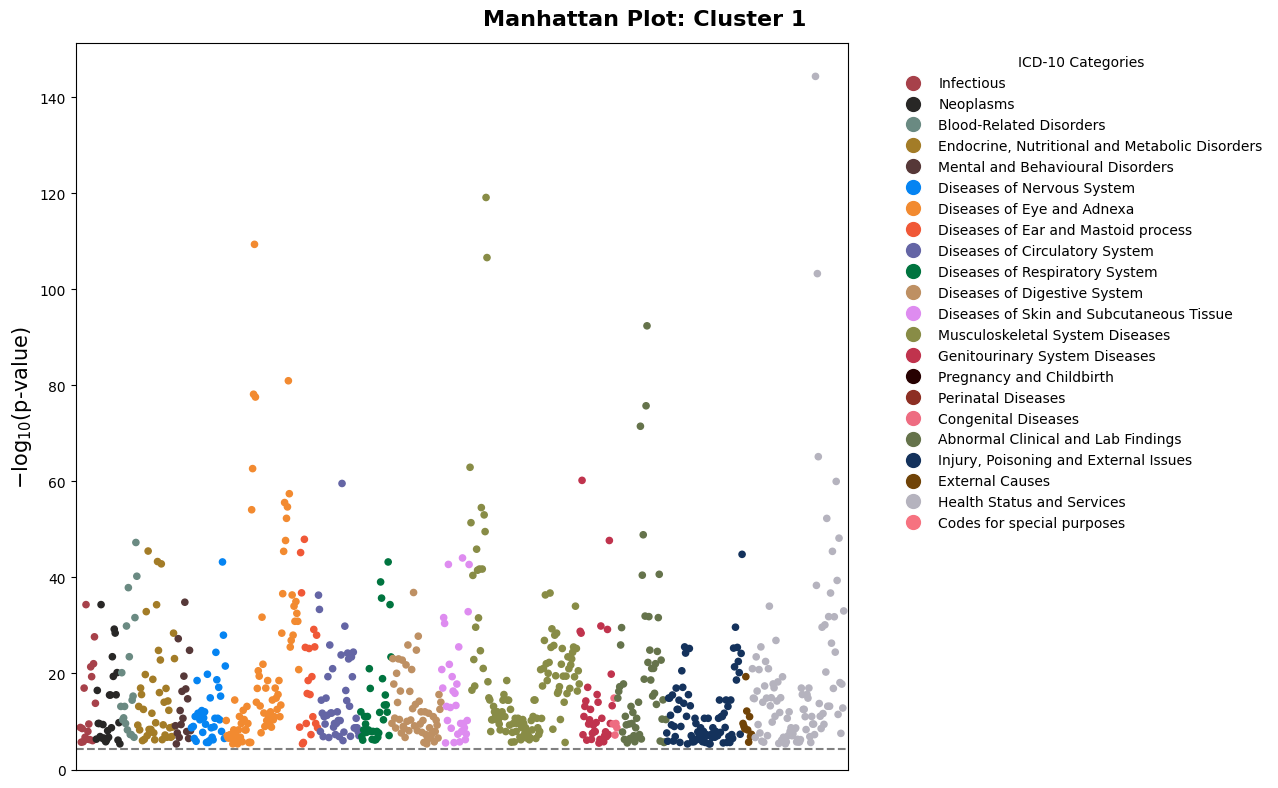

In [24]:
# Create a Manhattan plot (single plot)
fig, ax = plt.subplots(figsize=(13, 8))

# Dictionary to store legend handles
legend_handles = {}

# Main plot (Manhattan plot)
for name, group in cluster_icd_grouped:
    group_color = group['ICD10_chape_name'].map(lambda x: category_color_mapping.get(x, '#000000'))  # Get colors for group
    
    # Scatter plot for each ICD-10 category
    scatter = ax.scatter(group['ind'], group['-log_pvalue'], c=group_color, label=name, s=20)
    
    # Store legend handles to avoid duplicates
    if name not in legend_handles:
        legend_handles[name] = scatter

# Set axis limits
ax.set_ylim(0, None)  # Set the lower limit of the Y-axis to 0, with an auto-adjusted upper limit
ax.set_ylabel(r'$-\log_{10}$(p-value)', fontsize=15)

# Remove X-axis labels and ticks
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel("")  # Hide the X-axis label

# Adjust the X-axis range with padding
ax.set_xlim([cluster['ind'].min() - 5, cluster['ind'].max() + 5])  # Add margins on both sides

# Add a dashed horizontal line (Bonferroni correction threshold)
bc = 0.05 / cluster.shape[0]
ax.axhline(y=-np.log10(bc), linestyle='--', color='gray')

# Add a title
plt.suptitle('Manhattan Plot: Cluster 1', fontsize=16, fontweight='bold')

# Create a legend with ICD-10 categories
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label) 
           for label, color in category_color_mapping.items()]
ax.legend(handles=handles, title="ICD-10 Categories", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, markerscale=1.5, frameon=False)


# Adjust layout to prevent cropping
plt.tight_layout()

# Save and display the plot
plt.savefig("Figures/ManhattanPlot_Cluster1.pdf", dpi=600, format="pdf", bbox_inches="tight")
plt.show()

